In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
import joblib                                                                                                                                            
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter

In [2]:
data = pd.read_table('../data-2/total4.15.txt',sep='\t',index_col=0)

data_gt= data.loc[:, data.columns.str.contains('BC|NT|MC|PC')].T
data_gt = data_gt.apply(pd.to_numeric)
data_gt = data_gt.drop(index=['BC5.1', 'BC5.3'])
data_gt = data_gt.apply(pd.to_numeric)
data_gt.fillna(0, inplace=True) #35 canned
data_gt.columns = data['ID']
# data_gt = data_gt.loc[:, (data_gt != 0).any(axis=0)]
# data_gt

data_fjg= data.loc[:, ~data.columns.str.contains('BC|NT|MC|PC')].T
data_fjg.columns = data_fjg.iloc[0]
data_fjg = data_fjg[1:]
data_fjg = data_fjg.sort_index()
data_fjg = data_fjg.replace("#DIV/0!", 0)
data_fjg = data_fjg.apply(pd.to_numeric)
data_fjg.fillna(0, inplace=True) #54 samples
# data_fjg = data_fjg.loc[:, (data_fjg != 0).any(axis=0)]
# data_fjg

print(data_fjg.shape,data_gt.shape) 
# common_columns = data_gt.columns.intersection(data_fjg.columns)
# data_fjg = data_fjg.loc[:, common_columns]
# data_gt = data_gt.loc[:, common_columns]
# print(data_fjg.shape,data_gt.shape) 

(54, 2718) (35, 2718)


In [3]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
pearson_corr_values = []
for i in range(len(data_fjg)):
    corr_values = []
    for j in range(len(data_gt)):
        corr, _ = pearsonr(data_fjg.iloc[i], data_gt.iloc[j])
        corr_values.append(corr)
    pearson_corr_values.append(corr_values)

# Convert the result to a DataFrame
pearson_corr_matrix = pd.DataFrame(pearson_corr_values, index=data_fjg.index, columns=data_gt.index)
pearson_corr_matrix['sum'] = pearson_corr_matrix.sum(axis=1)
# pearson_corr_matrix

# Take the sum of each row, the sum of the similarity of all cans
pearson_corr_matrix['label'] = np.where(pearson_corr_matrix['sum'] > 1.5, 1, 0) # If the sum is greater than 0.5, set label to 1
# similarity_matrix
len(pearson_corr_matrix[pearson_corr_matrix['label'] == 1])

## Add labels for N1 and n2
data = pd.concat([data_fjg, data_gt])
data = data.loc[:, (data != 0).any(axis=0)]
X = data

Y = pearson_corr_matrix['label'].tolist() + [1] * len(data_gt)
Y = np.array(Y)

print(X.shape,Y.shape) 
Counter(Y) # To select 13 as 1 and 30 as 0, the baseline is guaranteed


(89, 2537) (89,)


Counter({0: 45, 1: 44})

In [4]:
pearson_corr_matrix

,NTB.2,NTB.3,NTJ.3,BC2.2,BC2.3,BC3.1,BC3.2,BC3.3,BC4.1,BC4.2,...,PC1.2,PC1.3,PC2.1,PC2.2,PC2.3,PC3.1,PC3.2,PC3.3,sum,label
16.1,0.001442,0.088340,0.172267,0.128959,0.104044,0.050008,0.041562,0.052076,0.162770,0.209747,...,-0.000249,0.003688,0.002292,0.001795,0.003191,0.000985,0.005285,0.001680,1.442378,0
16.2,-0.002298,0.026629,0.087774,0.056658,0.042955,0.022542,0.013730,0.017092,0.089930,0.100781,...,0.011792,0.036821,0.062288,0.058611,0.046521,0.030372,0.027299,0.046796,1.065710,0
16.3,-0.002822,0.013587,0.049211,0.031160,0.023019,0.011130,0.006640,0.008541,0.054650,0.056408,...,0.002524,0.046879,0.076360,0.073171,0.060547,0.041694,0.036565,0.062647,0.818912,0
16.4,0.005361,0.011720,0.041306,0.025381,0.018473,0.009275,0.005275,0.007223,0.042382,0.043356,...,0.004152,0.049766,0.079399,0.075845,0.067190,0.041896,0.038040,0.063419,0.981605,0
17.1,0.001014,0.103885,0.205208,0.153283,0.122645,0.058868,0.047686,0.059402,0.193326,0.240916,...,-0.002510,-0.000213,0.009268,-0.000817,0.004423,0.001564,0.000176,-0.000759,1.840251,1
17.2,0.001079,0.016355,0.031638,0.022434,0.017619,0.007932,0.006155,0.008278,0.035794,0.037498,...,0.011721,0.056065,0.098459,0.085300,0.072676,0.050672,0.044375,0.074867,0.828978,0
17.3,-0.000349,0.008757,0.033216,0.020145,0.014555,0.007746,0.003630,0.005132,0.033811,0.037361,...,0.006534,0.031371,0.060525,0.052284,0.044972,0.027199,0.025871,0.042397,1.196782,0
17.4,-0.002359,0.078148,-0.002695,0.028436,0.027484,0.005174,-0.000993,-0.000763,-0.002678,-0.002812,...,-0.003385,0.001710,-0.003891,-0.001097,0.027519,0.006372,0.004180,0.000077,0.411284,0
17.5,0.004245,0.013374,0.050053,0.030000,0.023465,0.013253,0.007587,0.009665,0.048322,0.048992,...,0.014357,0.056099,0.096874,0.084112,0.072981,0.049822,0.042821,0.073306,0.953509,0
18.1,0.004325,0.162242,0.338156,0.246488,0.199856,0.094671,0.076750,0.097172,0.312255,0.381109,...,-0.002140,0.002755,-0.000691,-0.000033,0.006784,0.000767,0.000226,0.000113,2.938003,1


In [5]:
pearson_corr_matrix.to_csv("./result_PPC_matrix.csv",sep=',')

In [167]:
# data = pearson_corr_matrix['label']
# data.index = data.index.astype(float) 
# data = data.sort_index() 
# data.to_csv("fjg_label.csv")

In [4]:
# Re-standardization and normalization
X  = Normalizer().fit_transform(X)
# X  = StandardScaler().fit_transform(X)
X  = MinMaxScaler().fit_transform(X)

In [5]:
# GDTB based: wrap-embedding
rfc = GradientBoostingClassifier(n_estimators=2,random_state=42)
# from sklearn.linear_model import LogisticRegression
# rfc = LogisticRegression()
n = 4
sfm = SelectFromModel(rfc, max_features = n) 
X_sn_new = sfm.fit_transform(X, Y)
print(X_sn_new.shape)

feature_importance = sfm.estimator_.feature_importances_
non_zero_indices = sfm.get_support(indices=True)
non_zero_indices = non_zero_indices.tolist()
all_f = data.columns.tolist()
feature = [all_f[i] for i in non_zero_indices]
print(len(feature),feature)
for i in feature:
    print(i)
    
X_k = X[:, non_zero_indices]
print(X_k.shape,Y.shape)

for i in non_zero_indices:
    print(i,feature_importance[i])

(89, 4)
4 ['1000149-94-5', '622-78-6', '1000152-34-3', '1000162-57-7']
1000149-94-5
622-78-6
1000152-34-3
1000162-57-7
(89, 4) (89,)
1122 0.07705627705627717
1239 0.7548105547343364
1688 0.0804268366006173
1813 0.024220328114262814


In [6]:
Counter(np.round(feature_importance, 3))

Counter({0.0: 2530, 0.02: 2, 0.024: 2, 0.077: 1, 0.755: 1, 0.08: 1})

In [149]:
# # Filter features
# new = non_zero_indices[1:]
# new = non_zero_indices[:1] + non_zero_indices[2:]
# new = non_zero_indices[:2] + non_zero_indices[3:]
# new = non_zero_indices[:3] + non_zero_indices[4:]
# new = non_zero_indices[:4] + non_zero_indices[5:]
# new = non_zero_indices[:5] + non_zero_indices[6:]
new = non_zero_indices[:6] + non_zero_indices[7:]

# new = non_zero_indices[:7] + non_zero_indices[8:]
# new = non_zero_indices[:8] + non_zero_indices[9:]
# new = non_zero_indices[:9] + non_zero_indices[10:]
X_k = X[:, new]
print(X_k.shape,Y.shape)

feature = [all_f[i] for i in new]
print(len(feature),feature)
# for i in feature:
#     print(i)
new,non_zero_indices

(89, 6) (89,)
6 ['140-67-0', '74630-80-1', '146934-31-8', '36144-40-8', '1116-52-5', '74841-63-7']


([130, 673, 686, 1122, 1239, 1688], [130, 673, 686, 1122, 1239, 1688, 1813])

In [6]:
# Create a 10fold cross validation object train
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
f1_scores = []
auc_scores = []
recall = []
precision = []
tpr_list = []
fpr_list = []

accuracies_train = []
f1_scores_train = []
auc_scores_train = []
recall_train = []
precision_train = []
tpr_list_train = []
fpr_list_train = []

# Use cross-validation to evaluate model performance
for train_idx, test_idx in cv.split(X_k, Y):
    X_train, X_test = X_k[train_idx], X_k[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    rfc.fit(X_train, Y_train)
    #train
    X_pred = rfc.predict(X_train)
    accuracy = accuracy_score(Y_train, X_pred)
    re = metrics.recall_score(Y_train, X_pred)
    pr = metrics.precision_score(Y_train, X_pred)
    f1 = f1_score(Y_train, X_pred)
    auc1 = roc_auc_score(Y_train, rfc.predict_proba(X_train)[:,1])
    fpr, tpr, _ = roc_curve(Y_train,  rfc.predict_proba(X_train)[:,1])

    accuracies_train.append(accuracy)
    f1_scores_train.append(f1)
    auc_scores_train.append(auc1)
    recall_train.append(re)
    precision_train.append(pr)
    tpr_list_train.append(tpr)
    fpr_list_train.append(fpr)

    #test
    Y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    re = metrics.recall_score(Y_test, Y_pred)
    pr = metrics.precision_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    auc1 = roc_auc_score(Y_test, rfc.predict_proba(X_test)[:,1])
    fpr, tpr, _ = roc_curve(Y_test,  rfc.predict_proba(X_test)[:,1])
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    accuracies.append(accuracy)
    recall.append(re)
    precision.append(pr)
    f1_scores.append(f1)
    auc_scores.append(auc1)

# print("Train result")
# Print the accuracy, F1 value, and AUC value for each cross-validation
for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies_train, recall_train,f1_scores_train, auc_scores_train), 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')

# Calculate the average accuracy, F1 value, and AUC value of cross-validation
average_accuracy = sum(accuracies_train) / len(accuracies_train)
average_recall = sum(recall_train) / len(recall_train)
average_f1 = sum(f1_scores_train) / len(f1_scores_train)
average_auc = sum(auc_scores_train) / len(auc_scores_train)
average_precision = sum(precision_train) / len(precision_train)


print(f'Average Accuracy = {average_accuracy:.4f}')
print(f'Average Recall = {average_recall:.4f}')
print(f'Average Precision = {average_precision:.4f}')
print(f'Average F1 Score = {average_f1:.4f}')
print(f'Average AUC = {average_auc:.4f}')

Fold 1: Accuracy = 0.9875, Recall = 0.9750,F1 Score = 0.9873, AUC = 0.9988
Fold 2: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 3: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 4: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 5: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 6: Accuracy = 0.9875, Recall = 0.9744,F1 Score = 0.9870, AUC = 0.9987
Fold 7: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 8: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 9: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 10: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Average Accuracy = 0.9975
Average Recall = 0.9949
Average Precision = 1.0000
Average F1 Score = 0.9974
Average AUC = 0.9997


In [7]:
# "Test result"
for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies, recall,f1_scores, auc_scores), 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')

# Calculate the average accuracy, F1 value, and AUC value of cross-validation
average_accuracy = sum(accuracies) / len(accuracies)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_scores) / len(f1_scores)
average_auc = sum(auc_scores) / len(auc_scores)
average_precision = sum(precision) / len(precision)
print(f'Average Accuracy = {average_accuracy:.4f}')
print(f'Average Recall = {average_recall:.4f}')
print(f'Average Precision = {average_precision:.4f}')
print(f'Average F1 Score = {average_f1:.4f}')
print(f'Average AUC = {average_auc:.4f}')

Fold 1: Accuracy = 0.7778, Recall = 0.7500,F1 Score = 0.7500, AUC = 0.8750
Fold 2: Accuracy = 0.7778, Recall = 1.0000,F1 Score = 0.8000, AUC = 0.8000
Fold 3: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 4: Accuracy = 0.8889, Recall = 0.7500,F1 Score = 0.8571, AUC = 0.8750
Fold 5: Accuracy = 0.8889, Recall = 0.7500,F1 Score = 0.8571, AUC = 0.8500
Fold 6: Accuracy = 0.6667, Recall = 0.4000,F1 Score = 0.5714, AUC = 0.9250
Fold 7: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 8: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 9: Accuracy = 0.8889, Recall = 1.0000,F1 Score = 0.9091, AUC = 0.8750
Fold 10: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Average Accuracy = 0.8889
Average Recall = 0.8650
Average Precision = 0.9250
Average F1 Score = 0.8745
Average AUC = 0.9200


In [9]:
feature_importance = rfc.feature_importances_
feature_importance = np.round(feature_importance, 2)
Counter(feature_importance)

Counter({0.07: 1, 0.77: 1, 0.11: 1, 0.05: 1})

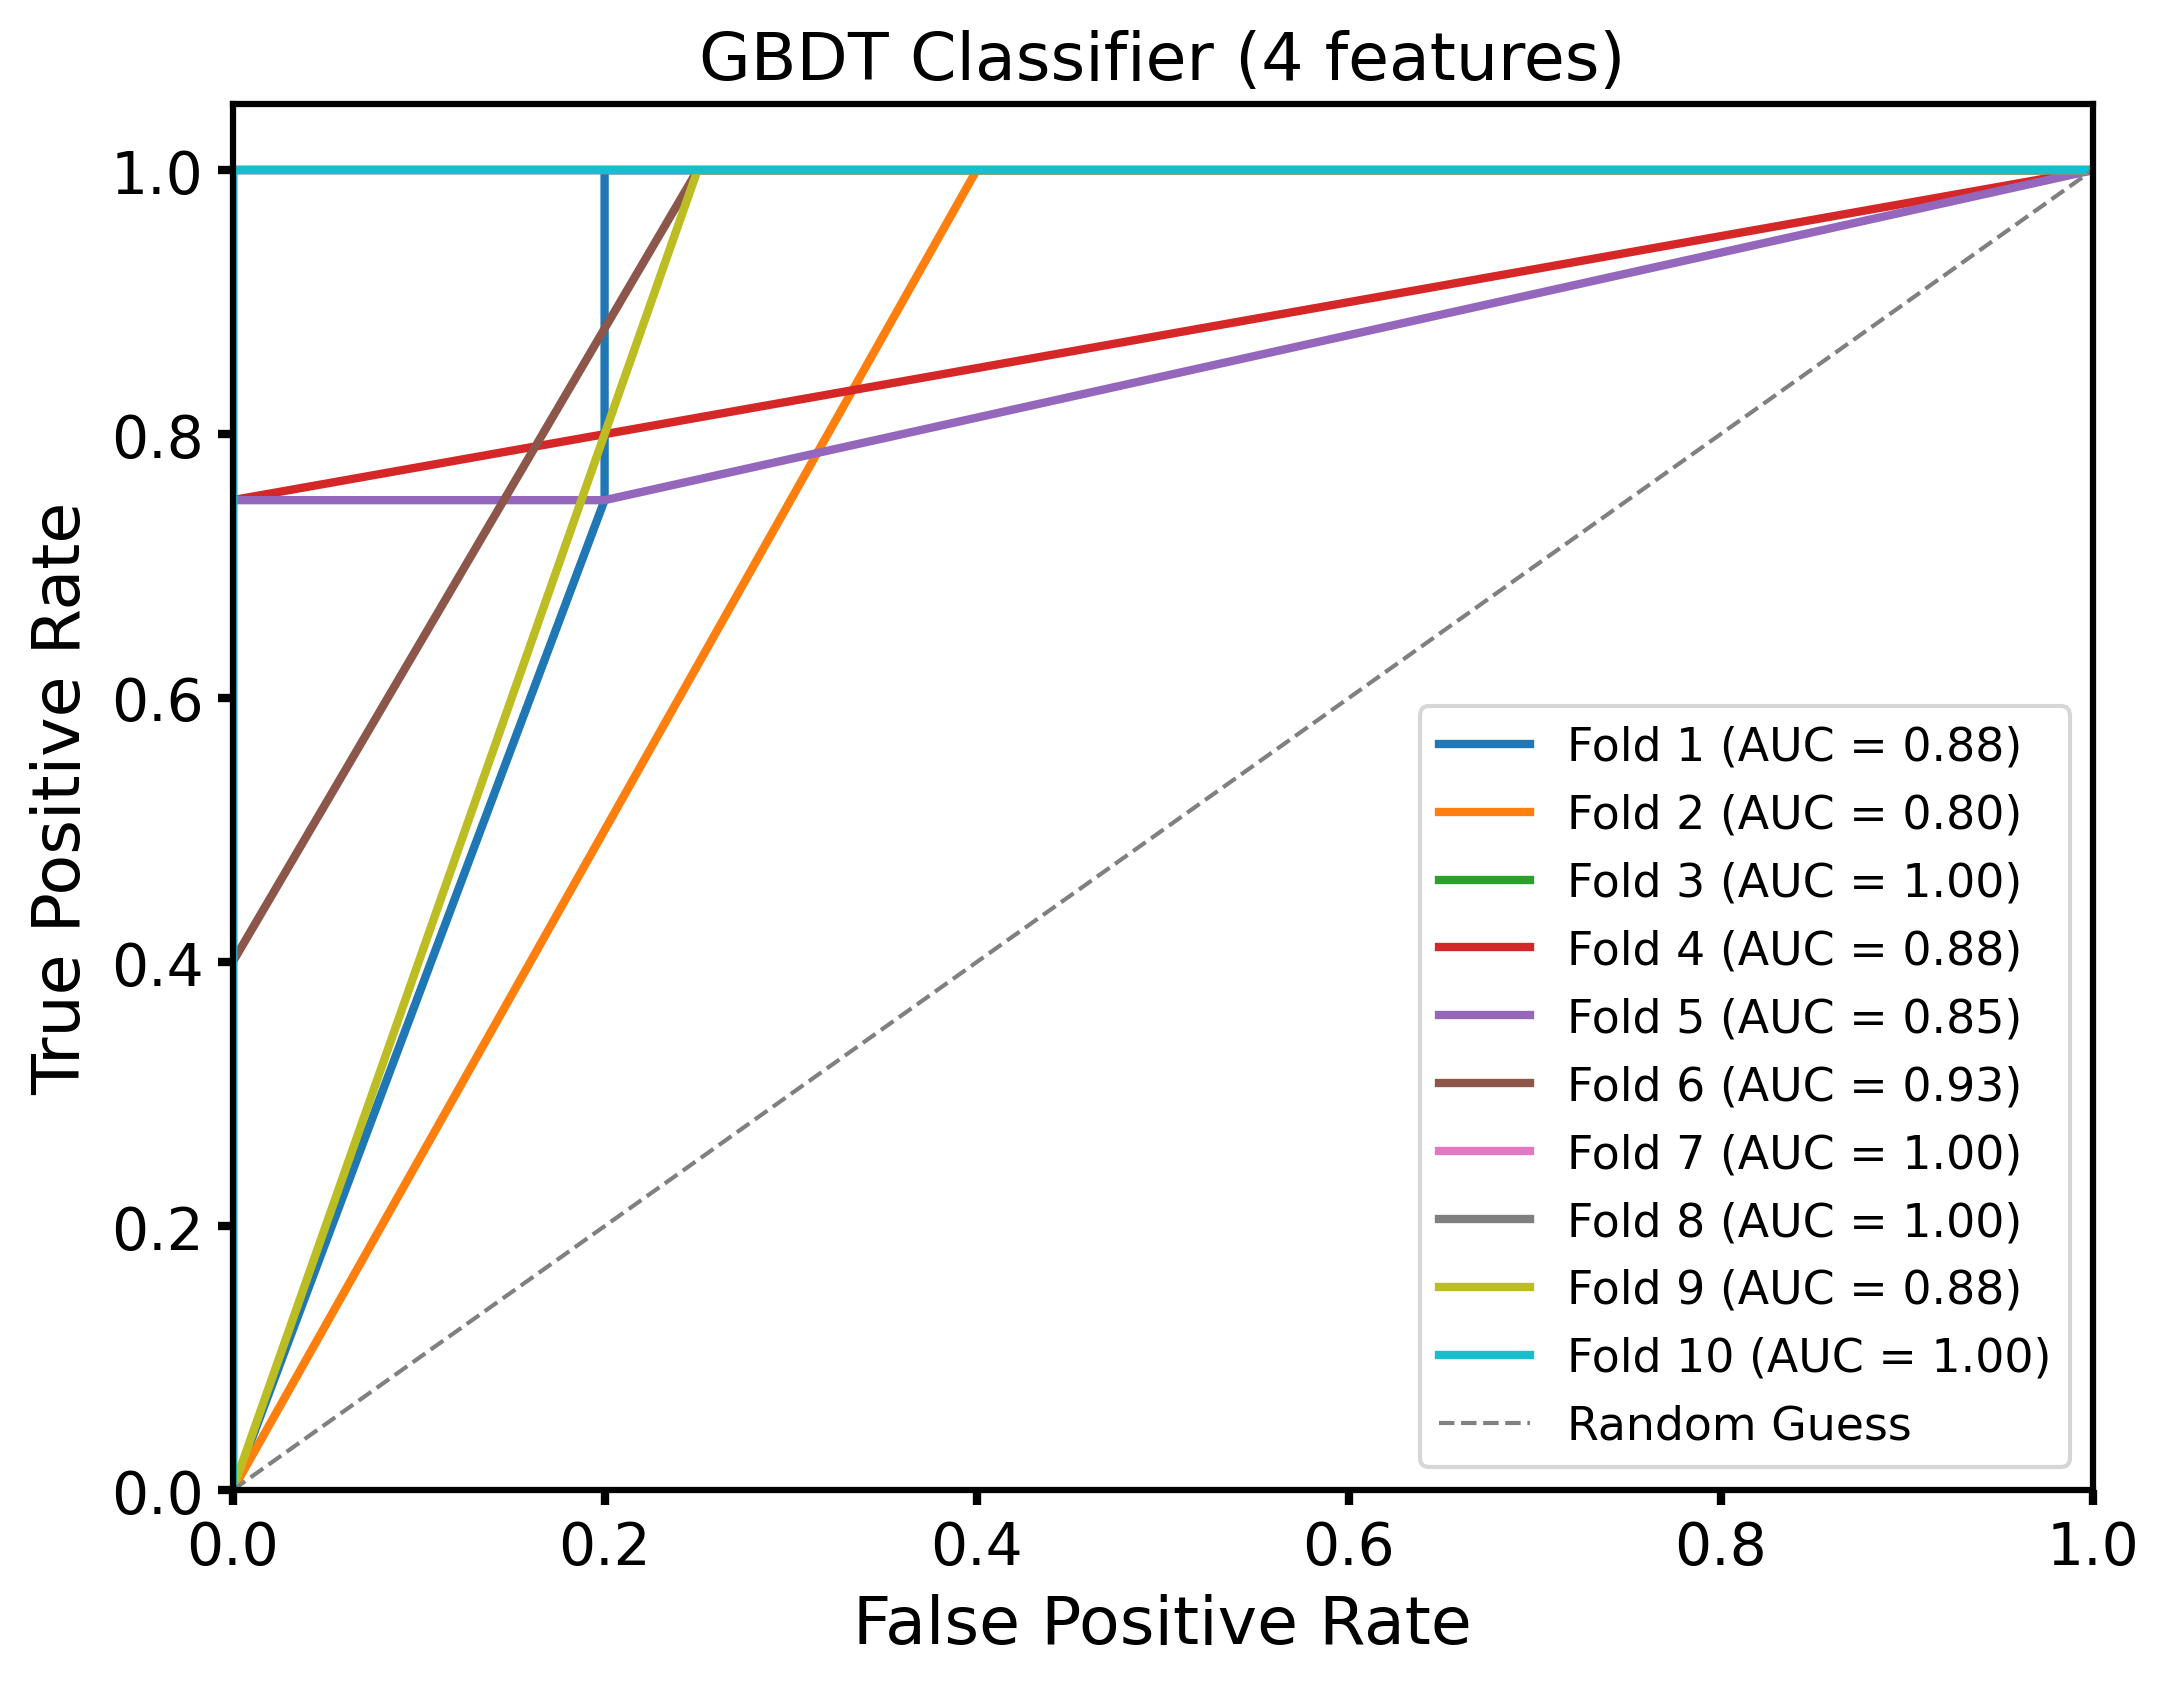

In [44]:
# Draw the ROC curve
plt.figure(figsize=(8, 6),dpi=300)
for i, (tpr, fpr, roc_auc) in enumerate(zip(tpr_list, fpr_list, auc_scores), 1):
    plt.plot(fpr, tpr, lw=2, label=f'Fold {i} (AUC = {roc_auc:.2f})')

# Draw ROC curves for random guesses
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=1,label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('GBDT Classifier (4 features)', fontsize=16)
plt.legend(loc='lower right', fontsize=11)



plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

plt.gca().tick_params(axis='both', which='major', width=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig("../code-2/result/GBDT-4F-ROC.pdf")
plt.savefig("../code-2/result/GBDT-4F-ROC.png")
plt.show()

In [11]:
joblib.dump(rfc, "../code-2/result/GBDT_Classifier-4f.joblib") #save model

['/data/public/dulin/fwwz/code-2/result/GBDT_Classifier-4f.joblib']